In [29]:
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from matplotlib import pyplot as plt
import plotly.express as px

import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler

from sklearn.preprocessing import StandardScaler,LabelEncoder
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm

In [128]:
def get_rank_weights(outputs, k):
    outputs_argsort = np.argsort(np.asarray(outputs))
    ranks = np.argsort(outputs_argsort)
    return 1 / (k * (1 + ranks))

def reduce_weight_variance(weights: np.array, data: np.array):
    weights_new = []
    data_new = []
    for w, d in zip(weights, data):
        if w == 0.0:
            continue
        while w > 1:
            weights_new.append(1.0)
            data_new.append(d)
            w -= 1
        weights_new.append(w)
        data_new.append(d)

    return np.array(weights_new), np.array(data_new)

In [ ]:
class WeightedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = None
        self.decoder = None
        self.fc_mu = None
        self.fc_logvar = None
        self.weights_k = 1e-3
        self.latent_dim = 32

    def build(self, input_dim):

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64, self.latent_dim)
        self.fc_logvar = nn.Linear(64, self.latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
        )

    def _reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        z = self._reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

    def _weights(self, X, y, optim_direc):
        if optim_direc == "min":
            c = -1
        if optim_direc == "max":
            c = 1
        else:
            c = 1
        ranked_weights = get_rank_weights(c * y, self.weights_k)
        normed_weights = ranked_weights / np.mean(ranked_weights)
        weights, X = reduce_weight_variance(normed_weights, X)
        return weights, X

    def fit(self, X, y, optim_direc=None):
        perc = np.percentile(y, 50)
        percentile_cutoff = y >= perc
        X = X[percentile_cutoff]
        y = y[percentile_cutoff]
        weights, X = self._weights(X, y, optim_direc)

        input_dim = X.shape[1]
        self.build(input_dim)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        weights = torch.tensor(weights, dtype=torch.float32)

        dataset = TensorDataset(X_tensor, weights)
        sampler = WeightedRandomSampler(weights, len(X))
        dataloader = DataLoader(dataset, batch_size=64, sampler=sampler, shuffle=False)
        optimizer = optim.Adam(self.parameters(), lr=5e-4)
        criterion = nn.MSELoss(reduction='none')

        for epoch in range(100):
            for xb, weights_b in dataloader:
                optimizer.zero_grad()
                recon, mu, logvar = self(xb)
                recon_loss = criterion(recon, xb).mean(dim=1)
                kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
                elbo = recon_loss + kl_div
                loss = torch.mean(elbo * weights_b)
                loss.backward()
                optimizer.step()

    def transform(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            encoded = self.encoder(X_tensor)
            mu = self.fc_mu(encoded)
        return mu.numpy()

    def fit_transform(self, X, y, optim_direc=None):
        self.fit(X, y, optim_direc)
        return self.transform(X)

In [164]:
if torch.tensor(1e100) < torch.tensor(2):
    print('cx')

In [131]:
from botorch.test_functions.synthetic import Ackley

In [158]:
x = torch.FloatTensor(1000, 10).uniform_(0, 5)
x2 = torch.FloatTensor(1000, 10).uniform_(30, 35)
x = torch.concat((x,x2))

In [159]:
funct = Ackley(dim=10, noise_std=None, negate=False, bounds=None, dtype=torch.float64)
y = funct(x)

C:\Users\danin\AppData\Local\Temp\ipykernel_30648\3143058258.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32)


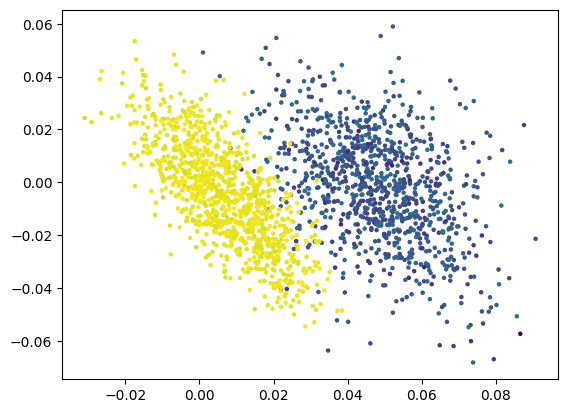

In [160]:
vae_result = Autoencoder().fit_transform(x, y)
vae_result
plt.scatter(vae_result[:, 0], vae_result[:, 1], c=y, cmap='viridis', s=5)